# GASS-HI: SMC foreground

# Libraries

In [1]:
import os
import sys
import glob
import pickle

import seaborn as sns
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from astropy.io.votable import from_table, parse_single_table, parse
from matplotlib.ticker import AutoMinorLocator
from scipy import interpolate
from scipy.odr import Model, ODR, RealData

In [2]:
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

from astropy.wcs import WCS
from spectral_cube import SpectralCube

In [3]:
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord
from astropy.wcs import utils

In [4]:
# sns.set(style="whitegrid")
# sns.set_context("paper")
plt.rc('text', usetex=False)
plt.rc('font', family='serif')

In [5]:
# plt.rc('font', weight='bold')
# plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=15)
# plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
mpl.rcParams['axes.linewidth'] = 2.

In [6]:
pd.set_option("display.max_columns", None)

In [7]:
import bisect

# Insert new element to the right order
a = [3, 4, 6, 8, 9, 11, 22]

val = 7

idx = bisect.bisect(a, val)
print(idx)

a.insert(idx, val)
print(a)

# or 1 line
bisect.insort(a, val)
print(a)

3
[3, 4, 6, 7, 8, 9, 11, 22]
[3, 4, 6, 7, 7, 8, 9, 11, 22]


In [8]:
# import libs.gfitflex as fitlib
script_dir = os.path.dirname(os.path.realpath('__file__'))
base_dir = os.path.abspath(os.path.join(script_dir, os.pardir))
sys.path.append(base_dir)
base_dir

'/Users/kiemhiep/opt/anaconda3/envs/gfit'

In [9]:
module_dir = os.path.join(base_dir, 'gaussfit', 'modules')
sys.path.append(module_dir)
module_dir

'/Users/kiemhiep/opt/anaconda3/envs/gfit/gaussfit/modules'

In [10]:
import gaussfit.modules.decomposer as dc
import gaussfit.modules.fit as find_gcomp
import libs.fitlibs as fitlibs

# Paths

In [11]:
base = os.path.expanduser('~')
askap = os.path.join(base, 'ANU', 'ASKAP')
LMC = os.path.join(askap, 'LMC')
LMC_plots = os.path.join(LMC, 'plots')
data_path = os.path.join(askap, 'data')
LMC_data_path = os.path.join(data_path, 'LMC')
LMC_bridge_data = os.path.join(LMC_data_path, 'bridge')
LMC_GASKAP_data = os.path.join(LMC_data_path, 'lmc_gaskap')

GASS_data_path = os.path.join(LMC_data_path, 'GASS')

gfit_path = os.path.join(LMC, 'gfit')
gfit_result_path = os.path.join(gfit_path, 'results')
LMC_abs_component_path = os.path.join(LMC_data_path, "absorption")


SMC = os.path.join(askap, 'SMC')
SMC_data_path = os.path.join(data_path, 'SMC')
SMC_fg_data_path = os.path.join(SMC_data_path, 'fg')
SMC_fg_abs_data_path = os.path.join(SMC_fg_data_path, 'spectra')
SMC_plots = os.path.join(SMC, 'plots')
SMC_fg_em_abs_plots = os.path.join(SMC_plots, 'em_abs_mw' )

GASS_SMC_data_path = os.path.join(SMC_data_path, 'GASS')
# SMC_neighbour_em_spec_path = os.path.join(SMC_data_path, 'neighbour_emission_spectra')
SMC_neighbour_em_spec_path = os.path.join(SMC_data_path, 'em_spectra')
GASS_SMC_subcube_dir = os.path.join(GASS_SMC_data_path, "subcubes")

smc_gfit_path = os.path.join(SMC, 'gfit')
smc_gfit_result_path = os.path.join(smc_gfit_path, 'results')

SMC_data_path

'/Users/kiemhiep/ANU/ASKAP/data/SMC'

# SMC HI map

In [12]:
data_file = os.path.join(GASS_data_path, 'GASS_HI_SMC_cube.fits')
hi_data = fits.open(data_file)  # Open the FITS file for reading
cube = SpectralCube.read(hi_data)  # Initiate a SpectralCube
hi_data.close()  # Close the FITS file - we already read it in and don't need it anymore!

print(f"Cube shape: {cube.shape}") # (vlsr, b, l) : (1153, 2251, 4500)

Cube shape: (971, 151, 314)


In [13]:
_, b, _ = cube.world[0, :, 0]  # extract latitude:  [-42, -26] deg
_, _, l = cube.world[0, 0, :]  # extract longitude: [265, 295] deg
vlsr, _, _ = cube.world[:, 0, 0]  # extract velocity

print("Longitude l = ", l[0], l[1], '...', l[-2], l[-1])
print("Latitude b = ", b[0], b[1], '...', b[-2], b[-1])
print("Velocity = ", vlsr[0], vlsr[1], '...', vlsr[-2], vlsr[-1])

Longitude l =  315.04 deg 314.96 deg ... 290.08 deg 290.0 deg
Latitude b =  -52.0 deg -51.92 deg ... -40.08 deg -40.0 deg
Velocity =  -399882.500231401 m / s -399058.000207082 m / s ... 399058.02333371 m / s 399882.5233580289 m / s


# Fcn

In [14]:
def votable_to_pandas(votable_file):
    votable = parse(votable_file)
    table = votable.get_first_table().to_table(use_names_over_ids=True)
    return table.to_pandas()


def get_source_infor(df, field_id, source):
    src_info = df.loc[(df["comp_name"] == source) & (df["sbid"] == field_id)]
    nfound = len(src_info['comp_name'].unique())
    
    if nfound == 0:
        print("Error: No source found!")
        return None

    if nfound == 1:
        return src_info.iloc[0]
    else:
        print("Error: source is not unique!")
        return None


def get_source_info_from_name(df, source):
    src_info = df.loc[df["comp_name"] == source]
    nfound = len(src_info['comp_name'].unique())
    
    if nfound == 0:
        print("Error: No source found!")
        return None
    
    return src_info.iloc[0]

In [15]:
# linear model
def linear_fcn(p, x):
    m, b = p
    return m*x + b

In [37]:
def read_fits_cube(filename):
    """
    Read 

    Parameters
    ----------
    filename (string) : filename of FITS file
    Input data.

    Returns
    -------
    cube
    WCS
    X-coordinates
    Y-coordinates
    Velocity

    Other parameters
    ----------------
    None
    """
        
    # Read FITS file
    dat = fits.open(filename)  # Open the FITS file for reading
    c = SpectralCube.read(dat)  # Initiate a SpectralCube
    
    # c = c[:, 10:29, 10:29]

    # Parse the WCS keywords in the primary HDU
    hdr = dat[0].header
    # w = WCS(hdr)
    
    w = WCS(naxis=2)
    w.wcs.crpix = [hdr['CRPIX1'], hdr['CRPIX2']]
    w.wcs.cdelt = np.array([hdr['CDELT1'], hdr['CDELT2']])
    w.wcs.crval = [hdr['CRVAL1'], hdr['CRVAL2']]
    w.wcs.ctype = [hdr['CTYPE1'], hdr['CTYPE2']]


    dat.close()  # Close the FITS file - we already read it in and don't need it anymore!

    print(f"Cube shape: {c.shape}") # (vlsr, b, l) : (971, 201, 376)

    del dat
    # cube = cube.with_spectral_unit(u.km / u.s)
    
    _, _, x = c.world[0, 0, :]      # extract RA: deg
    _, y, _ = c.world[0, :, 0]     # extract DEC:  deg
    v, _, _ = c.world[:, 0, 0]    # extract velocity
    
    return c, w, x, y, v, hdr

# Number of observed fields

In [17]:
all_dirs = glob.glob( os.path.join(smc_gfit_result_path, 'sb*') )
fields = [x.replace(gfit_result_path+'/', '') for x in all_dirs]
print("Number of fields:", )
n_fields = len(fields)
fields

Number of fields:


[]

# Moment Maps

In [18]:
# Moment Maps
moment0_file = os.path.join(GASS_data_path, 'moment0_SMC_fg.fits')
m0_header = fits.open(moment0_file)  # Open the FITS file for reading
# m0.close()  # Close the FITS file - we already read it in and don't need it anymore!
m0 = fits.getdata(moment0_file)
print(m0.shape)

# Parse the WCS keywords in the primary HDU
hdr = m0_header[0].header
w = WCS(hdr)

(151, 314)


# Read SMC catalogue

All SMC sightlines

In [19]:
smc_spectra_filename = os.path.join(SMC_fg_data_path, "askap_spectra.vot")

df = votable_to_pandas(smc_spectra_filename)
nrows, ncols = df.shape
print(f"Number of rows {nrows},\n Number of columns: {ncols}")
df.head(3)

Number of rows 366,
 Number of columns: 26


,id,comp_name,ra,dec,glon,glat,rating,flux_peak,flux_int,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,has_mw_abs,has_other_abs,semi_maj_axis,semi_min_axis,pa,n_h,noise_flag
0,0,J005611-710707,14.047569,-71.118705,302.378431,-46.004439,A,348.412994,377.468994,0.002837,0.004445,0.120564,4.944155,1.020283,148.0,0.899718,-0.789069,0.105673,0.005650,True,True,5.18,4.445,6.880000,1.236612e+21,False
1,1,J005611-710707,14.047569,-71.118705,302.378431,-46.004439,A,348.412994,377.468994,0.002837,0.004445,0.120564,4.944155,1.020283,148.0,0.899718,-0.789069,0.105673,0.005650,True,True,5.18,4.445,6.880000,1.236612e+21,False
2,2,J012257-751508,20.737784,-75.252405,300.252864,-41.711512,A,333.157990,334.123993,0.003061,0.010025,0.223565,6.574020,1.029517,78.0,0.805952,7.211650,0.215731,0.015474,True,False,5.02,4.245,21.690001,3.544263e+20,False


In [20]:
# df.info()
# df.isnull().sum()

In [21]:
df_unique_SMC = df.drop_duplicates(subset=["comp_name"])
print("Unique source subset toward SMC")
print(f"Shape: {df_unique_SMC.shape}")
n_sightlines = df_unique_SMC.shape[0]
df_unique_SMC.head(3)

Unique source subset toward SMC
Shape: (365, 26)


,id,comp_name,ra,dec,glon,glat,rating,flux_peak,flux_int,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,has_mw_abs,has_other_abs,semi_maj_axis,semi_min_axis,pa,n_h,noise_flag
0,0,J005611-710707,14.047569,-71.118705,302.378431,-46.004439,A,348.412994,377.468994,0.002837,0.004445,0.120564,4.944155,1.020283,148.0,0.899718,-0.789069,0.105673,0.005650,True,True,5.180,4.445,6.880000,1.236612e+21,False
2,2,J012257-751508,20.737784,-75.252405,300.252864,-41.711512,A,333.157990,334.123993,0.003061,0.010025,0.223565,6.574020,1.029517,78.0,0.805952,7.211650,0.215731,0.015474,True,False,5.020,4.245,21.690001,3.544263e+20,False
3,3,J012256-751504,20.735863,-75.251329,300.253275,-41.712653,A,165.660995,160.867996,0.003069,0.009579,0.210114,6.996270,1.026276,82.0,0.816163,8.189289,0.203141,0.014647,True,False,5.215,3.955,33.299999,3.544263e+20,False


In [22]:
# Check duplicates
print(f"[Comp_name] Duplicated? => {df['comp_name'].duplicated().any()}")
# data[data.duplicated(['comp_name'], keep=False)]

# Show the duplicates
# df[df.duplicated(['comp_name']) == True]
# Example:
df.loc[df["comp_name"] == "J060004-703837"]

[Comp_name] Duplicated? => True


,id,comp_name,ra,dec,glon,glat,rating,flux_peak,flux_int,mean_cont,sd_cont,opacity_range,max_s_max_n,max_noise,num_chan_noise,min_opacity,vel_min_opacity,peak_tau,e_peak_tau,has_mw_abs,has_other_abs,semi_maj_axis,semi_min_axis,pa,n_h,noise_flag


In [23]:
# all columns
print("All columns: \n", ', '.join(df.columns))
# df.dtypes

All columns: 
 id, comp_name, ra, dec, glon, glat, rating, flux_peak, flux_int, mean_cont, sd_cont, opacity_range, max_s_max_n, max_noise, num_chan_noise, min_opacity, vel_min_opacity, peak_tau, e_peak_tau, has_mw_abs, has_other_abs, semi_maj_axis, semi_min_axis, pa, n_h, noise_flag


## Spectral Rating

In [24]:
print(f"Types of ratings: {df_unique_SMC['rating'].unique()}")

Types of ratings: ['A' 'B' 'C' 'D']


In [25]:
rating_info = df_unique_SMC['rating'].value_counts()
rating_types = rating_info.index.to_list()
print(f"Rating types: {rating_types}")

rating_counts = rating_info.values
print(f"Rating counts: {rating_counts}")

n_ratings = len(rating_types)

Rating types: ['B', 'A', 'C', 'D']
Rating counts: [260  49  33  23]


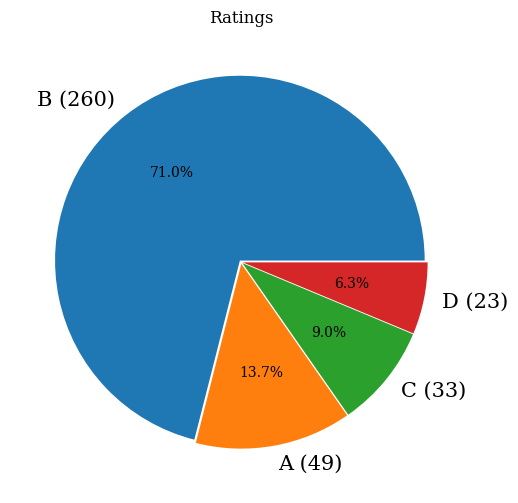

In [26]:
colors = ['g', 'r']
explode = [0.01]*n_ratings
labels = [rating_types[i]+' (' + str(rating_counts[i]) + ')' for i in range(n_ratings)]

plt.figure(figsize=(6,6))
plt.pie(df['rating'].value_counts(normalize=True)*100,
        colors=None,
        labels=labels,
        explode=explode,
        autopct='%1.1f%%',
        shadow=False)

plt.title('Ratings')
plt.show()

## Sources on map

In [27]:
src_ra_SMC = df_unique_SMC['ra'].values
src_dec_SMC = df_unique_SMC['dec'].values
src_gl_SMC = df_unique_SMC['glon'].values
src_gb_SMC = df_unique_SMC['glat'].values

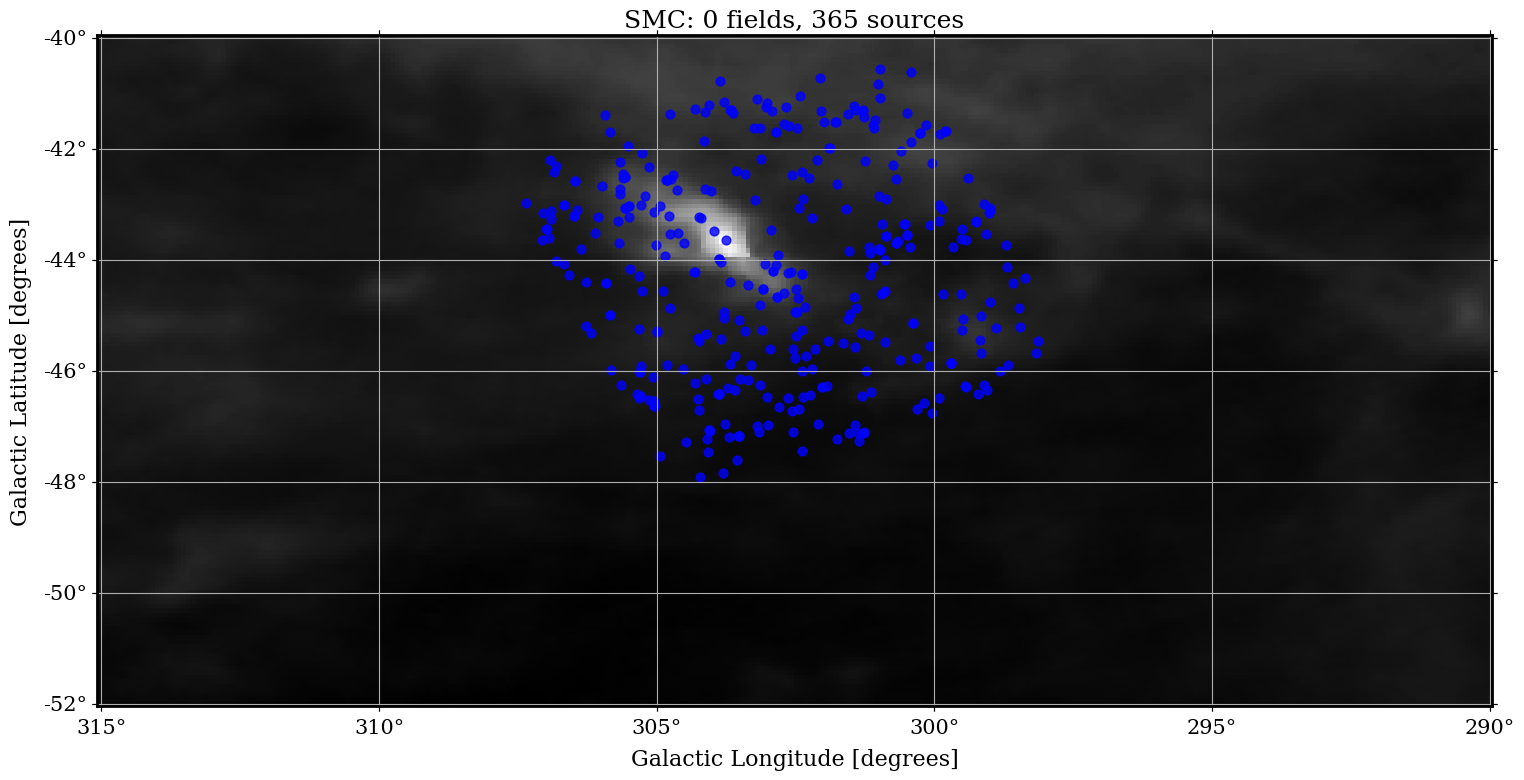

In [28]:
# Plot
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=w)

# Display the moment map image
im = ax.imshow(0.018224 * m0, cmap='gray')
# ax.invert_yaxis()  # Flips the Y axis
# ax.invert_xaxis()  # Flips the X axis


# sct = ax.scatter(src_gl_LMC, src_gb_LMC, s=40, transform=ax.get_transform('galactic'),
#            marker='s', c=noise_LMC_percent,
#            cmap='jet',
#            norm=mpl.colors.LogNorm(vmin=noise_LMC_percent_min, vmax=100.),
#            label='MW')

sct = ax.scatter(src_gl_SMC, src_gb_SMC, s=40, transform=ax.get_transform('galactic'), marker='o', c='b', alpha=0.8, label='MW')

# Title
ax.set_title(f"SMC: {n_fields} fields, {n_sightlines} sources", fontsize=18)

# Add axes labels
ax.set_xlabel("Galactic Longitude [degrees]", fontsize=16)
ax.set_ylabel("Galactic Latitude [degrees]", fontsize=16)

# Add a colorbar
# cbar = plt.colorbar(im, pad=.07)
# cbar.set_label('Velocity (km/s)', size=16)

## Color bar
# cbar = fig.colorbar(sct, ax=ax, orientation='vertical', fraction=0.02, pad=0.006, aspect=35)
# cbar.ax.set_ylabel('Optical Depth Noise [%]', rotation=90, labelpad=5., fontsize=15)
# cbar.ax.tick_params(labelsize=14)

# Overlay set of RA/Dec Axes
# overlay = ax.get_coords_overlay('fk5')
# overlay.grid(color='white', ls='dotted', lw=2)
# overlay[0].set_axislabel('Right Ascension (J2000)', fontsize=16)
# overlay[1].set_axislabel('Declination (J2000)', fontsize=16)

# Overplot column density contours 
# levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22)  # Define contour levels to use
# ax.contour(NHI.hdu.data, cmap='Greys_r', alpha=0.5, levels=levels)

plt.grid()
plt.show()

In [29]:
print(f"GLON range: {src_gl_SMC.min()}, {src_gl_SMC.max()}")
print(f"GLAT range: {src_gb_SMC.min()}, {src_gb_SMC.max()}")

GLON range: 298.13767990528993, 307.3508123845972
GLAT range: -47.90624873112368, -40.57250149487181


# Read SMC GASS cube 

In [30]:
cube_file = os.path.join(GASS_data_path, 'GASS_HI_SMC_foreground_cube.fits')
cube_file

'/Users/kiemhiep/ANU/ASKAP/data/LMC/GASS/GASS_HI_SMC_foreground_cube.fits'

In [52]:
# cube, header = fits.getdata(cube_file, header=True)
# print(cube.shape)

cube, cube_wcs, subcube_ra, subcube_dec, subcube_vlsr, header = read_fits_cube(cube_file)
print(cube_wcs)
print(cube)

Cube shape: (243, 151, 314)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-CAR'  'GLAT-CAR'  
CRVAL : 0.0  0.0  
CRPIX : -561.0  651.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.08  0.08  
NAXIS : 0  0
SpectralCube with shape=(243, 151, 314) and unit=K:
 n_x:    314  type_x: GLON-CAR  unit_x: deg    range:   290.000000 deg:  315.040000 deg
 n_y:    151  type_y: GLAT-CAR  unit_y: deg    range:   -52.000000 deg:  -40.000000 deg
 n_s:    243  type_s: VOPT      unit_s: m / s  range:   -99764.491 m / s:   99764.515 m / s


In [53]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  314                                                  
NAXIS2  =                  151                                                  
NAXIS3  =                  243                                                  
BLANK   =                   -1  /                                               
BUNIT   = 'K       '  /                                                         
TELESCOP= 'ATNF Parkes 64-'  /                                                  
CELLSCAL= 'CONSTANT'  /                                                         
RESTFREQ=    1.42040575200E+09  /                                               
OBJECT  = 'GASS_III Galactic HI Survey'  /                                      
OBSERVER= 'Kalberla & Haud' 

In [54]:
nchan, ny, nx = cube.shape
print(nchan, ny, nx)

243 151 314


In [73]:
subcube_vlsr = np.array(subcube_vlsr)/1000.

In [74]:
dv = np.mean(np.abs(np.diff(subcube_vlsr)))
dv

0.8245000243189997

In [56]:
mom0 = cube.with_spectral_unit(u.km/u.s).moment(order=0)  # Zero-th moment 
# mom1 = subcube.with_spectral_unit(u.km/u.s).moment(order=1)  # First moment
# mom2 = subcube.with_spectral_unit(u.km/u.s).moment(order=2)  # 2nd moment

In [57]:
cube = np.array(cube)

In [50]:
nhi_thin = np.sum(cube, axis=0) * dv * 1.82243e-2

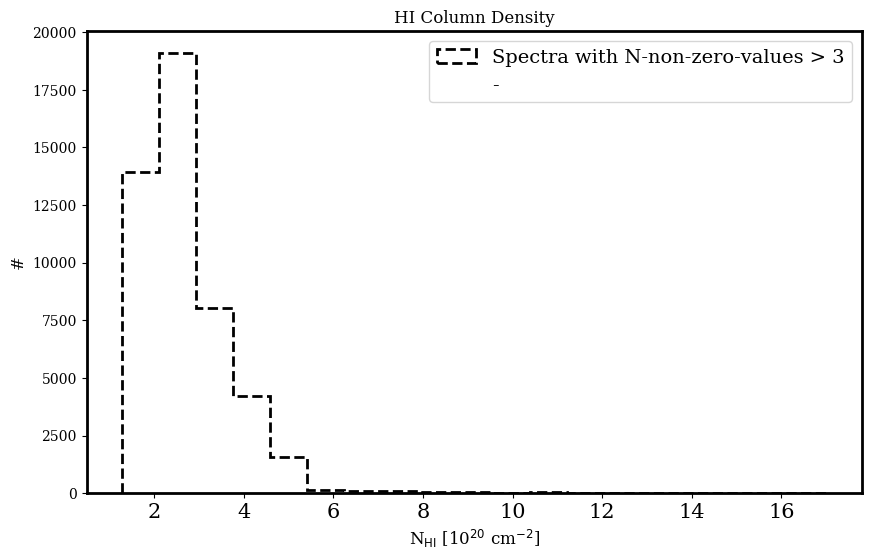

In [61]:
# from scipy import stats
plt.figure(figsize=(10, 6))

nhi_flatten = nhi_thin.flatten()

nhi_min = np.min(nhi_flatten)
nhi_max = np.max(nhi_flatten)

counts, bins, bars = plt.hist(nhi_flatten,
                              bins=np.linspace(nhi_min, nhi_max, 20),
         density=False, color='k', histtype='step', alpha=1.,
         ls='--', lw=2, label=r'Spectra with N-non-zero-values > 3')

ploti, = plt.plot([], [], '', label=f"-")
ploti.set_visible(False)

plt.title('HI Column Density')
plt.xlabel('N$_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', fontsize=12)
plt.ylabel(r'#', fontsize=12)

plt.legend(loc='upper right', fontsize=14)
plt.show()

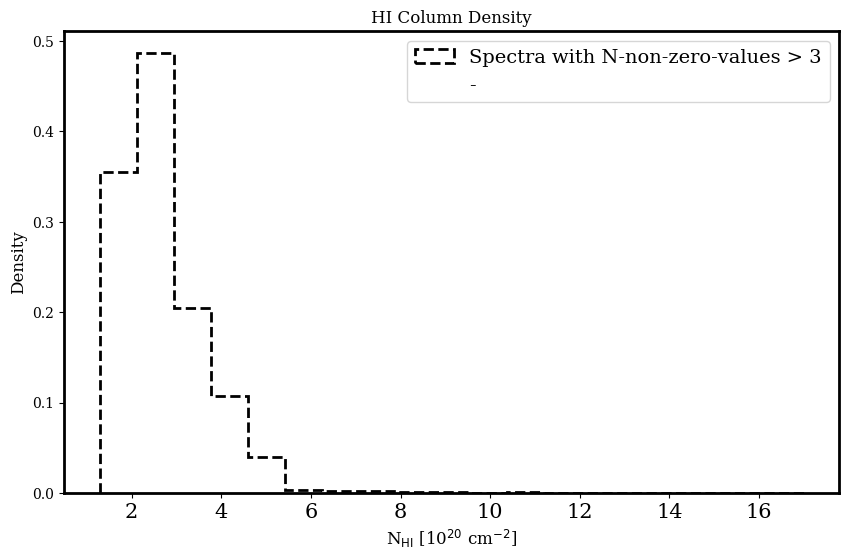

In [65]:
# from scipy import stats
plt.figure(figsize=(10, 6))

nhi_flatten = nhi_thin.flatten()

nhi_min = np.min(nhi_flatten)
nhi_max = np.max(nhi_flatten)

counts, bins, bars = plt.hist(nhi_flatten,
                              bins=np.linspace(nhi_min, nhi_max, 20),
         density=True, color='k', histtype='step', alpha=1.,
         ls='--', lw=2, label=r'Spectra with N-non-zero-values > 3')

ploti, = plt.plot([], [], '', label=f"-")
ploti.set_visible(False)

plt.title('HI Column Density')
plt.xlabel('N$_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.legend(loc='upper right', fontsize=14)
plt.show()

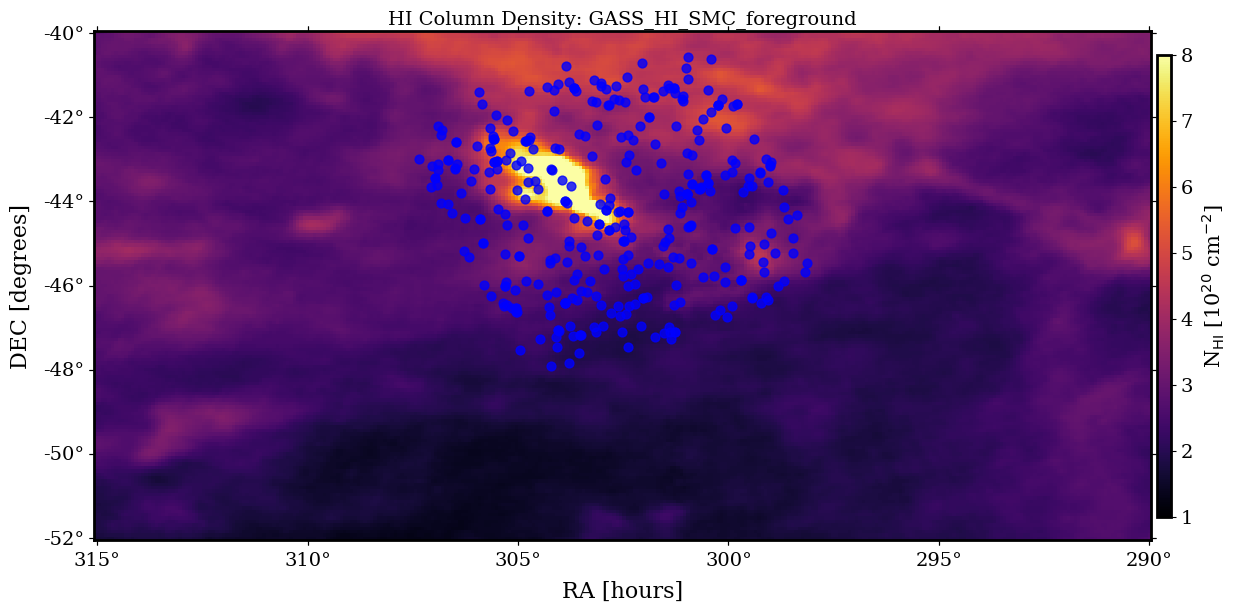

In [66]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection=mom0.wcs)

# moment map image
im = ax.imshow(nhi_thin, cmap='inferno', vmin=1., vmax=8.)

sct = ax.scatter(src_gl_SMC,
                 src_gb_SMC,
                 s=40,
                 transform=ax.get_transform('galactic'),
                 marker='o',
                 c='b',
                 alpha=0.8,
                 label='MW')

# Title
ax.set_title('HI Column Density: GASS_HI_SMC_foreground', fontsize=14)

# Add axes labels
ax.set_xlabel("RA [hours]", fontsize=16)
ax.set_ylabel("DEC [degrees]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel('N$_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=15)
# cbar.ax.set_ylabel(mom0.unit, rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

# plt.legend(loc='upper left', fontsize=12)
# plt.grid()
plt.show()

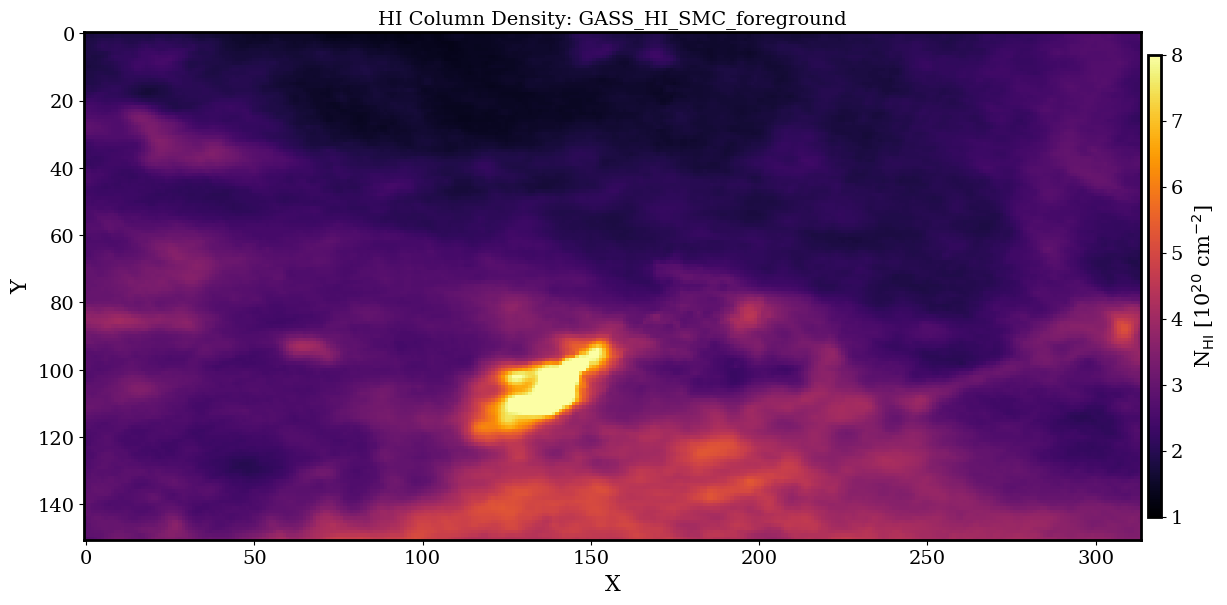

In [87]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# moment map image
im = ax.imshow(nhi_thin, cmap='inferno', vmin=1., vmax=8.)

# Title
ax.set_title('HI Column Density: GASS_HI_SMC_foreground', fontsize=14)

# Add axes labels
ax.set_xlabel("X", fontsize=16)
ax.set_ylabel("Y", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel('N$_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=15)
# cbar.ax.set_ylabel(mom0.unit, rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

# plt.legend(loc='upper left', fontsize=12)
# plt.grid()
plt.show()

In [71]:
xid_hgt, yid_hgt = np.where(nhi_thin > 6.)
print(len(xid_hgt))

474


In [85]:
mw_idx = np.where(subcube_vlsr < 60.)[0]

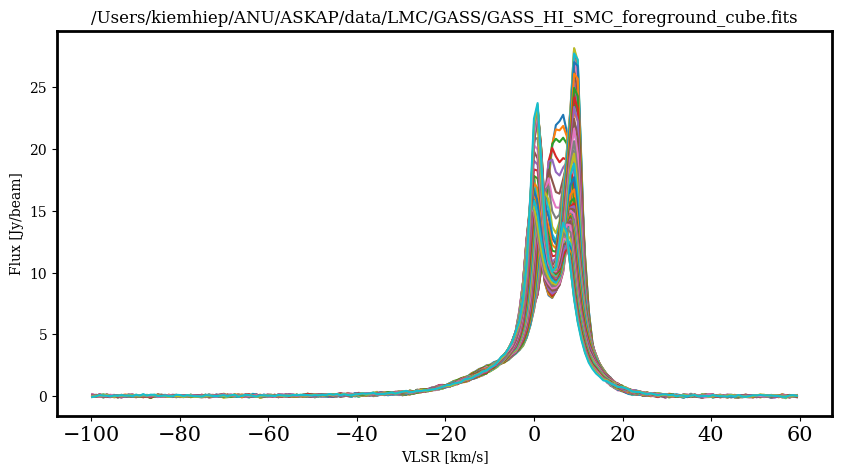

In [89]:
fig = plt.figure(figsize=(10,5))

for i in range(60):
    plt.plot(subcube_vlsr[mw_idx], cube[:, 150, 80+i][mw_idx])

plt.title(cube_file)
plt.xlabel('VLSR [km/s]')
plt.ylabel('Tb [K]')
plt.ylabel('Flux [Jy/beam]')
fig.savefig('', bbox_inches='tight')   # save the figure to file
plt.show()

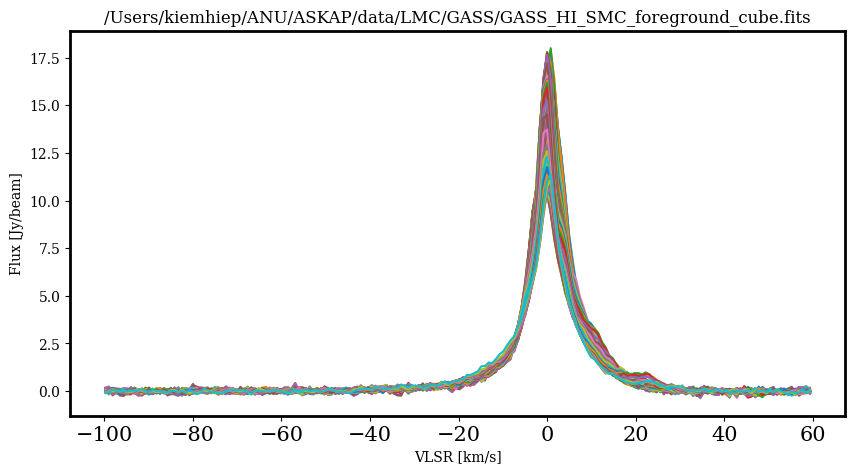

In [90]:
fig = plt.figure(figsize=(10,5))

for i in range(80):
    plt.plot(subcube_vlsr[mw_idx], cube[:, 100, 100+i][mw_idx])

plt.title(cube_file)
plt.xlabel('VLSR [km/s]')
plt.ylabel('Tb [K]')
plt.ylabel('Flux [Jy/beam]')
fig.savefig('', bbox_inches='tight')   # save the figure to file
plt.show()